In [1]:
import time
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np

from sklearn.model_selection import train_test_split

from tqdm import tqdm

from concrete.ml.torch.compile import compile_torch_model

import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from torchsummary import summary

/home/local/ASURITE/nnjungle/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
#hyperparams
no_epochs = 6
batch_size = 2
learning_rate = 0.001

In [4]:
#transform the dataset into tensors normalized range [-1, 1]
transform = transforms.Compose(
            [transforms.ToTensor(),
            transforms.Normalize((0.5),(0.5))     
        ])

In [5]:
#data sets downloading and reading
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                        train=True,
                                        download=True,
                                        transform=transform
                                        )

test_dataset = torchvision.datasets.MNIST(root='data',
                                        train=False,
                                        download=True,
                                        transform=transform
                                        )


In [6]:
# Extract features (images) and labels from MNIST dataset
mnist_features = train_dataset.data.numpy().reshape(-1, 28, 28)
mnist_labels = train_dataset.targets.numpy()

# Reshape and expand dimensions to match the structure of load_digits dataset
x_train_mnist = np.expand_dims(mnist_features, 1)

# Split the MNIST data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(
    x_train_mnist, mnist_labels,  train_size=5000, test_size=2, shuffle=True, random_state=42
)

x_train = x_train.astype('float64')
print(x_train.dtype)
print(x_train.shape)

# print(x_train)
# plt.imshow(x_train[0,0], cmap='grey')
# plt.show()
# Verify the shapes
print("Shape of x_train from MNIST:", x_train.shape)
print("Shape of x_test from MNIST:", x_test.shape)
print("Shape of y_train from MNIST:", y_train.shape)
print("Shape of y_test from MNIST:", y_test.shape)

float64
(5000, 1, 28, 28)
Shape of x_train from MNIST: (5000, 1, 28, 28)
Shape of x_test from MNIST: (2000, 1, 28, 28)
Shape of y_train from MNIST: (5000,)
Shape of y_test from MNIST: (2000,)


The Dataloaders - used to load data into application for use

In [7]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                            batch_size=batch_size,
                            shuffle=True
                            )

test_loader = torch.utils.data.DataLoader(test_dataset,
                                    batch_size=batch_size,
                                    shuffle=False
                                    )


we need to spilt the data here and 
convert it into a format that can be used with compile_torch_model

In [8]:
# from torchsummary import summary
# class ConvolutionalNeuralNet(nn.Module):
#     def __init__(self, n_classes) -> None:
#         """Construct the CNN with a configurable number of classes."""
#         super().__init__()

#         self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
#         self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
#         self.conv3 = nn.Conv2d(64, 64, kernel_size=3)
#         self.fc1 = nn.Linear(64 * 3 * 3, 64)
#         self.fc2 = nn.Linear(64, n_classes)
#         self.flatten = nn.Flatten()

#     def forward(self, x):
#         x= self.conv1(x)
#         x = torch.relu(x)
#         x = self.pool(x)
#         x = self.conv2(x)
#         x = torch.relu(x)
#         x = self.pool(x)
#         x = self.conv3(x)
#         x = torch.relu(x)
#         x = x.flatten(1)
#         x = self.fc1(x)
#         x = torch.relu(x)
#         x = self.fc2(x)
#         return x
    
# summary(ConvolutionalNueralNet(10), (1,28,28), device='cpu')


In [9]:
class ConvolutionalNeuralNet(nn.Module):
    def __init__(self, n_classes) -> None:
        """Construct the CNN with a configurable number of classes."""
        super().__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=3)
        self.fc1 = nn.Linear(64 * 8 * 8, 64)
        self.fc2 = nn.Linear(64, n_classes)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x= self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.conv3(x)
        x = torch.relu(x)
        x = x.flatten(1)
        x = torch.relu(x)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        return x
    
summary(ConvolutionalNeuralNet(10), (1,28,28), device='cpu')


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
            Conv2d-3             [-1, 64, 8, 8]          36,928
            Linear-4                   [-1, 64]         262,208
            Linear-5                   [-1, 10]             650
Total params: 318,602
Trainable params: 318,602
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.48
Params size (MB): 1.22
Estimated Total Size (MB): 1.70
----------------------------------------------------------------


In [10]:
net = ConvolutionalNeuralNet(10).to(device)

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

### Training Unencrypted

Training: 100%|██████████| 6/6 [10:49<00:00, 108.30s/it]


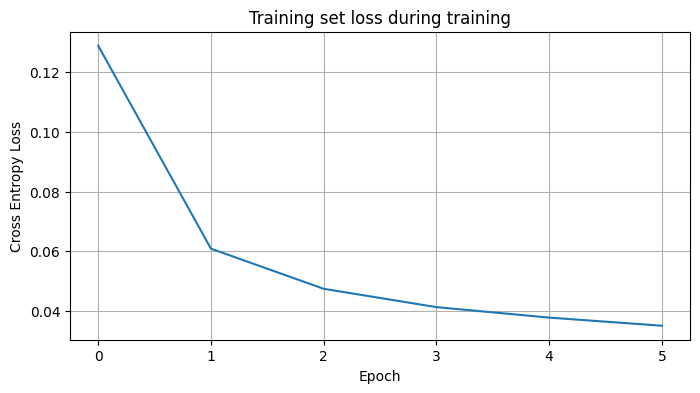

In [12]:
torch.manual_seed(42)

def train_one_epoch(net, optimizer, train_loader):
    # Cross Entropy loss for classification when not using a softmax layer in the network
    loss = nn.CrossEntropyLoss()

    net.train()
    avg_loss = 0
    for data, target in train_loader:
        optimizer.zero_grad()
        output = net(data)
        loss_net = loss(output, target.long())
        loss_net.backward()
        optimizer.step()
        avg_loss += loss_net.item()

    return avg_loss / len(train_loader)

# Create the tiny CNN with 10 output classes
N_EPOCHS = no_epochs

# Train the network with Adam, output the test set accuracy every epoch
losses_bits = []
optimizer = torch.optim.Adam(net.parameters())
for _ in tqdm(range(N_EPOCHS), desc="Training"):
    losses_bits.append(train_one_epoch(net, optimizer, train_loader))

fig = plt.figure(figsize=(8, 4))
plt.plot(losses_bits)
plt.ylabel("Cross Entropy Loss")
plt.xlabel("Epoch")
plt.title("Training set loss during training")
plt.grid(True)
plt.show()

In [13]:
def test_torch(net, test_loader):
    """Test the network: measure accuracy on the test set."""

    # Freeze normalization layers
    net.eval()

    # Determine the total number of samples in the dataset
    total_samples = len(test_loader.dataset)

    all_y_pred = np.zeros((total_samples,), dtype=np.int64)
    all_targets = np.zeros((total_samples,), dtype=np.int64)

    # Iterate over the batches
    idx = 0
    for data, target in test_loader:
        # Accumulate the ground truth labels
        endidx = idx + target.shape[0]
        all_targets[idx:endidx] = target.numpy()

        # Run forward and get the predicted class id
        output = net(data).argmax(1).detach().numpy()
        all_y_pred[idx:endidx] = output

        idx = endidx

    # Print out the accuracy as a percentage
    n_correct = np.sum(all_targets == all_y_pred)
    accuracy = n_correct / total_samples * 100
    print(f"Test accuracy: {accuracy:.2f}%")
    

# Call the test function
test_torch(net, test_loader)

Test accuracy: 98.71%


In [14]:
#Work now with concrete

def test_with_concrete(quantized_module, test_loader, use_sim):
    """Test a neural network that is quantized and compiled with Concrete ML."""

    total_samples = len(test_loader.dataset)

    all_y_pred = np.zeros((total_samples,), dtype=np.int64)
    all_targets = np.zeros((total_samples,), dtype=np.int64)

    # Iterate over the test batches and accumulate predictions and ground truth labels in a vector
    idx = 0
    for data, target in tqdm(test_loader):
        data = data.numpy()
        target = target.numpy()

        fhe_mode = "simulate" if use_sim else "execute"

        # Quantize the inputs and cast to appropriate data type
        y_pred = quantized_module.forward(data, fhe=fhe_mode)

        endidx = idx + target.shape[0]

        # Accumulate the ground truth labels
        all_targets[idx:endidx] = target

        # Get the predicted class id and accumulate the predictions
        y_pred = np.argmax(y_pred, axis=1)
        all_y_pred[idx:endidx] = y_pred

        # Update the index
        idx += target.shape[0]
        # break

    # Compute and report results
    n_correct = np.sum(all_targets == all_y_pred)

    return n_correct / len(test_loader)
    #return n_correct

In [15]:
n_bits = 4

q_module = compile_torch_model(
    net, 
    x_train, 
    rounding_threshold_bits=3, 
    p_error=0.1,
    n_bits=n_bits
)

In [16]:

#q_module = compile_brevitas_qat_model(net, x_train)
start_time = time.time()
accs = test_with_concrete(
    q_module,
    train_loader,
    use_sim=True,
)
sim_time = time.time() - start_time

print(f"Simulated FHE execution for {n_bits} bit network accuracy: {accs:.2f}%")

100%|██████████| 30000/30000 [08:42<00:00, 57.41it/s]

Simulated FHE execution for 4 bit network accuracy: 0.20%


In [17]:
# Generate keys first
t = time.time()
q_module.fhe_circuit.keygen()
print(f"Keygen time: {time.time()-t:.2f}s")

Keygen time: 4.09s


In [ ]:
from torch.utils.data import DataLoader, TensorDataset
test_dataset = TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test))
test_loader = DataLoader(test_dataset, batch_size=1)

In [18]:

t = time.time()
accuracy_test = test_with_concrete(
    q_module,
    test_loader,
    use_sim=False,
)
elapsed_time = time.time() - t
time_per_inference = elapsed_time / len(test_loader)
accuracy_percentage = 100 * accuracy_test

print(
    f"Time per inference in FHE: {time_per_inference:.2f} "
    f"with {accuracy_percentage:.2f}% accuracy"
)

  0%|          | 2/5000 [51:33<2156:28:39, 1553.29s/it]